# Deep learning in genomics - Custom ResNet model with PyTorch and fastai

This notebook is based on the [jupyter notebook](https://nbviewer.jupyter.org/github/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
# fastai version
__version__

'1.0.38.dev0'

# Data setup

Loading data from the web, generating dthe ataframe, and saving it to disk is carried out in [Basic model with PyTorch jupyter notebook](https://nbviewer.jupyter.org/github/MicPie/genomics/blob/master/DL_Genomics_v8_basic-pytorch.ipynb).

## Data frame setup

In [5]:
seq_df = pd.read_csv('seq_df.csv', index_col=0)

In [6]:
# add column NoTarget which is not(Target)
seq_df['NotTarget'] = seq_df['Target'].apply(lambda x: int(not(bool(x))))

In [7]:
seq_df.head()

,Sequences,Target,NotTarget
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0,1
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0,1
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0,1
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1,0
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1,0


## fastai data object

### Data encoding test (incorporated into "open_seq_image" function in the next section)

In [86]:
# setup class instance to encode the four different bases to integer values (1D)
int_enc = LabelEncoder()

In [87]:
# setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
one_hot_enc = OneHotEncoder(categories=[range(4)])

In [88]:
seq_enc = []

for s in seq:
    enc = int_enc.fit_transform(list(s)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    seq_enc.append(enc.toarray()) # export sparse matrix to np array

In [89]:
len(seq_enc)

2000

In [462]:
seq_enc[0].T, seq_enc[0].T.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

In [311]:
PIL.Image.fromarray(seq_enc[0].T.astype('uint8')*255).convert('P')

### Setup custom fastai data object

In [8]:
# open sequence image function
def open_seq_image(seq:str, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')).convert('P')
    x = pil2tensor(x,np.float32)
    
    # optional functions not needed
    #x = x.view(4,-1) # remove first dimension
    #x = x.expand(3, 4, 50) # expand to 3 channel image
    
    return cls(x)

In [9]:
# test open sequence image function
open_seq_image('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC')

In [10]:
class SeqItemList(ImageItemList):
    "Sequence Item List"
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq): return open_seq_image(seq)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, cols:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and return cls and df."
        return cls(items=df[cols].values, xtra=df)

In [11]:
bs = 64

In [12]:
data = (SeqItemList.import_from_df(seq_df, ['Sequences'])
        .random_split_by_pct(valid_pct=0.25)
        #.split_by_idxs(range(1500), range(1500,2000))
        .label_from_df(['Target', 'NotTarget'])
        .databunch(bs=bs))

### Verify data object

#### Check data object

In [17]:
data

ImageDataBunch;

Train: LabelList
y: MultiCategoryList (1500 items)
[MultiCategory NotTarget, MultiCategory NotTarget, MultiCategory Target, MultiCategory Target, MultiCategory NotTarget]...
Path: .
x: SeqItemList (1500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Valid: LabelList
y: MultiCategoryList (500 items)
[MultiCategory Target, MultiCategory NotTarget, MultiCategory NotTarget, MultiCategory NotTarget, MultiCategory Target]...
Path: .
x: SeqItemList (500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Test: None

In [18]:
# check classes
data.c, data.classes

(2, ['Target', 'NotTarget'])

In [19]:
data.train_dl.batch_size

64

#### Check data points

In [21]:
i = 2
data.x[i]

In [22]:
data.y[i]

MultiCategory Target

In [23]:
i = 3
data.x[i]

In [24]:
data.y[i]

MultiCategory Target

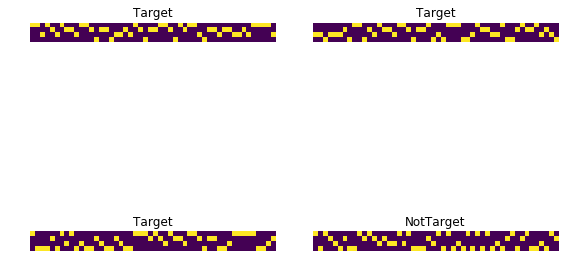

In [25]:
data.show_batch(rows=2)

# Model setup

## Custom fastai ResNet model

In [13]:
learn_dummy = create_cnn(data, models.resnet18)

In [14]:
learn_dummy.loss_func.func

BCEWithLogitsLoss()

In [15]:
#learn_dummy.model[0]

In [16]:
learn_dummy.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

### Setup custom input stage

In [17]:
# define function to create 3 channel image from 1 channel image.
def ExpandInput(): return Lambda(lambda x: x.expand(-1, 3, 4, 50))

In [18]:
EI = ExpandInput()

#### Test ExpandInput layer

In [19]:
tt = torch.rand((64,1,4,50)); tt.shape

torch.Size([64, 1, 4, 50])

In [20]:
tt.expand(-1, 3, 4, 50).shape

torch.Size([64, 3, 4, 50])

In [21]:
Image(EI(tt)[0])

### Insert custom input stage

In [22]:
net_custom_resnet = nn.Sequential(ExpandInput(), learn_dummy.model) # insert ExpandInput layer at the beginning of the network

In [23]:
# run dummy data through custom input stage to test it
net_custom_resnet[0](tt).shape

torch.Size([64, 3, 4, 50])

# Model training

## Tensorboard logger

In [35]:
import tensorflow as tf

# From https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
"""Simple example on how to log scalars and images to tensorboard without tensor ops.
License: Copyleft
"""
#__author__ = "Michael Gygli"

#import tensorflow as tf
#from StringIO import StringIO
#import matplotlib.pyplot as plt
#import numpy as np

class Logger(object):
    """Logging in tensorboard without tensorflow ops."""

    def __init__(self, log_dir):
        """Creates a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def log_scalar(self, tag, value, step):
        """Log a scalar variable.
        Parameter
        ----------
        tag : basestring
            Name of the scalar
        value
        step : int
            training iteration
        """
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag,
                                                     simple_value=value)])
        self.writer.add_summary(summary, step)

    def log_images(self, tag, images, step):
        """Logs a list of images."""

        im_summaries = []
        for nr, img in enumerate(images):
            # Write the image to a string
            s = StringIO()
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            im_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, nr),
                                                 image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=im_summaries)
        self.writer.add_summary(summary, step)
        

    def log_histogram(self, tag, values, step, bins=1000):
        """Logs the histogram of a list/vector of values."""
        # Convert to a numpy array
        values = np.array(values)
        
        # Create histogram using numpy        
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill fields of histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Requires equal number as bins, where the first goes from -DBL_MAX to bin_edges[1]
        # See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/summary.proto#L30
        # Thus, we drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()
        
"A `Callback` that saves tracked metrics into a log file for Tensorboard."
# Based on https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
# and devforfu: https://nbviewer.jupyter.org/gist/devforfu/ea0b3fcfe194dad323c3762492b05cae
# Contribution from MicPie

#from ..torch_core import *
#from ..basic_data import DataBunch
#from ..callback import *
#from ..basic_train import Learner, LearnerCallback
#import tensorflow as tf

__all__ = ['TBLogger']

@dataclass
class TBLogger(LearnerCallback):
    "A `LearnerCallback` that saves history of metrics while training `learn` into log files for Tensorboard."
    
    log_dir:str = 'logs'
    log_name:str = 'data'
    log_scalar:bool = True # log scalar values for Tensorboard scalar summary
    log_hist:bool = True # log values and gradients of the parameters for Tensorboard histogram summary
    log_img:bool = False # log values for Tensorboard image summary

    def __post_init__(self): 
        super().__post_init__()
    #def __init__(self):
    #    super().__init__()
        self.path = self.learn.path
        (self.path/self.log_dir).mkdir(parents=True, exist_ok=True) # setup logs directory
        self.Log = Logger(str(self.path/self.log_dir/self.log_name))
        self.epoch = 0
        self.batch = 0
        self.log_grads = {}
    
    def on_backward_end(self, **kwargs:Any):
        self.batch = self.batch+1
        #print('\nBatch: ',self.batch)
        
        if self.log_hist:
            for tag, value in learn.model.named_parameters():
                tag_grad = tag.replace('.', '/')+'/grad'
                
                if tag_grad in self.log_grads:
                    #self.log_grads[tag_grad] += value.grad.data.cpu().detach().numpy()
                    self.log_grads[tag_grad] = self.log_grads[tag_grad] + value.grad.data.cpu().detach().numpy() # gradients are summed up from every batch
                    #print('if')
                else:
                    self.log_grads[tag_grad] = value.grad.data.cpu().detach().numpy()
                    #print('else')
                
                #print(tag_grad, self.log_grads[tag_grad].sum())
        return self.log_grads
    
    #def on_step_end(self, **kwards:Any):
        #print('Step end: ', self.log_grads)

    def on_epoch_end(self, epoch:int, smooth_loss:Tensor, last_metrics:MetricsList, **kwargs:Any) -> bool:
        last_metrics = ifnone(last_metrics, [])
        tr_info = {name: stat for name, stat in zip(self.learn.recorder.names, [epoch, smooth_loss] + last_metrics)}
        self.epoch = tr_info['epoch']
        self.batch = 0 # reset batch count
        #print('\nEpoch: ',self.epoch)
        
        if self.log_scalar:
            for tag, value in tr_info.items():
                if tag == 'epoch': continue
                self.Log.log_scalar(tag, value, self.epoch+1)
                
        if self.log_hist:
            for tag, value in learn.model.named_parameters():
                
                tag = tag.replace('.', '/')
                self.Log.log_histogram(tag, value.data.cpu().numpy(), self.epoch+1)
                
                tag_grad = tag.replace('.', '/')+'/grad'
                self.Log.log_histogram(tag_grad, self.log_grads[tag_grad], self.epoch+1)
                #print(tag_grad, self.log_grads[tag_grad].sum())
                
        #if self.log_img:
        #    for tag, value in learn.model.named_parameters():
        #        
        #        tag = tag.replace('.', '/')
        #        self.Log.log_images(tag, value.data.cpu().numpy(), self.epoch+1)

## Train custom fastai ResNet with fastai 

In [24]:
learn_resnet = Learner(data, net_custom_resnet, metrics=accuracy_thresh)

In [45]:
#[p.shape for p in net_custom_resnet.parameters()]

In [46]:
learn_resnet.summary()

Layer (type)         Output Shape         Param #    Trainable 
Lambda               [64, 3, 4, 50]       0          False     
______________________________________________________________________
Conv2d               [64, 64, 2, 25]      9408       False     
______________________________________________________________________
BatchNorm2d          [64, 64, 2, 25]      128        True      
______________________________________________________________________
ReLU                 [64, 64, 2, 25]      0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 1, 13]      0          False     
______________________________________________________________________
Conv2d               [64, 64, 1, 13]      36864      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 1, 13]      128        True      
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


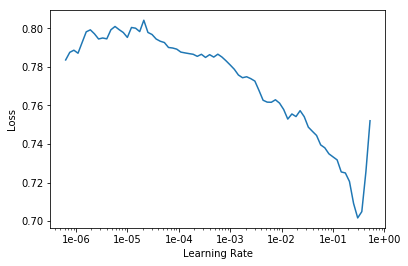

In [42]:
learn_resnet.lr_find()
learn_resnet.recorder.plot()

In [25]:
learn_resnet.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.777768,0.793338,0.515000
2,0.692816,0.765466,0.633000


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/MMP/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/MMP/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/MMP/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/MMP/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/MMP/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/MMP/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/MMP/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + 

KeyboardInterrupt: 

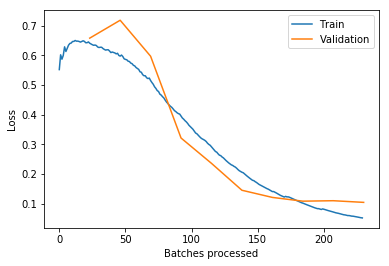

In [48]:
learn_resnet.recorder.plot_losses()

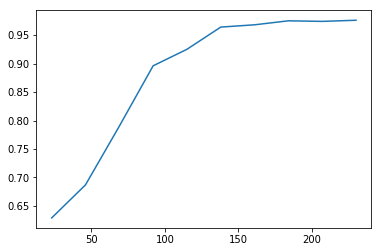

In [49]:
learn_resnet.recorder.plot_metrics()